In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = "/kaggle/input/german-credit/german_credit_data.csv"
df = pd.read_csv(file_path)

# Drop index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Check dataset info
print("Dataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

# Fill missing values
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

print("Dataset Info after dealing with missing values:")
print(df.isnull().sum())

# Encode categorical variables
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB
None

Missing Values:
 Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Dataset Info after dealing with missing values:
Age                 0
Se

Outliers detected in Age: 23


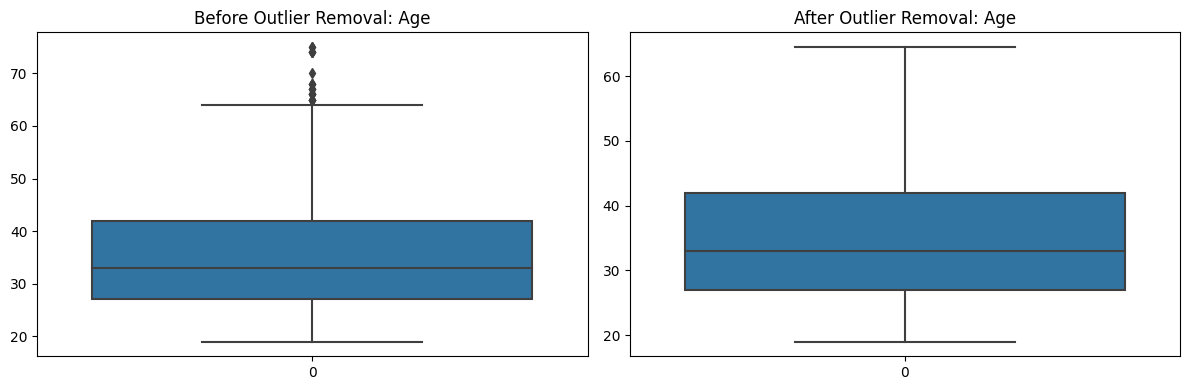

Outliers detected in Credit amount: 72


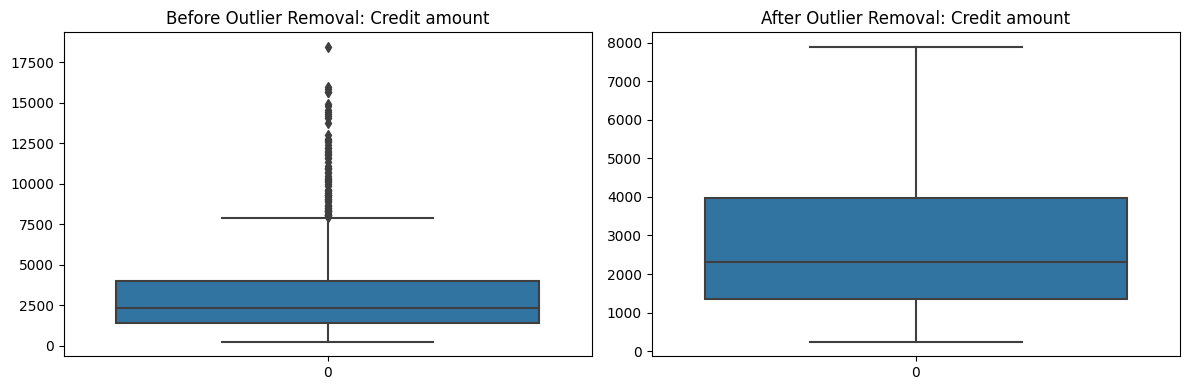

Outliers detected in Duration: 70


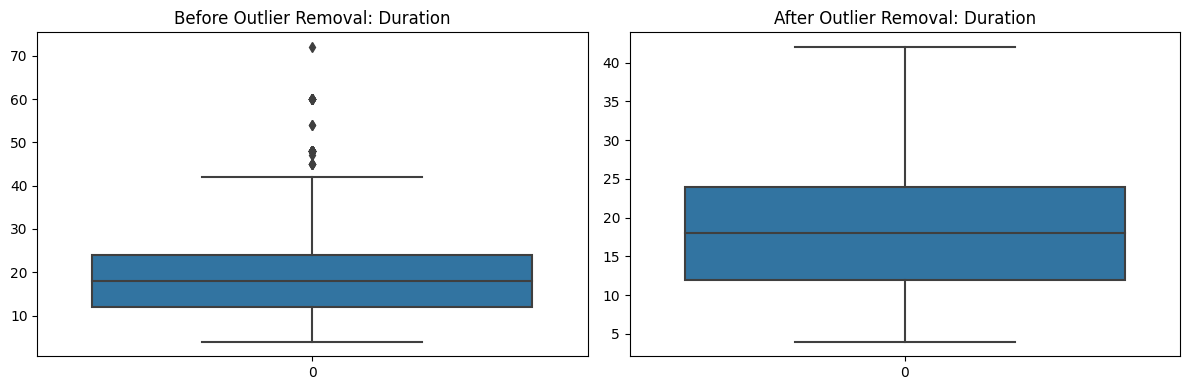

In [2]:
# Numerical columns for outlier check
num_cols = ['Age', 'Credit amount', 'Duration']

# Function to detect and handle outliers using IQR
def handle_outliers_if_present(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Check if outliers are present
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    if outliers > 0:
        print(f"Outliers detected in {column}: {outliers}")
        
        # Visualize before handling outliers
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df[column])
        plt.title(f"Before Outlier Removal: {column}")
        
        # Handle outliers by capping
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        
        # Visualize after handling outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df[column])
        plt.title(f"After Outlier Removal: {column}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No outliers detected in {column}. Skipping.")

# Create a copy of the original data for comparison
original_data = df.copy()

# Apply outlier handling to numerical features
for col in num_cols:
    handle_outliers_if_present(df, col)

In [3]:
# Feature Engineering
df['Credit_per_month'] = df['Credit amount'] / df['Duration']
df['Is_young'] = (df['Age'] < 25).astype(int)

# Final preview
print("\nFinal Dataset Preview:")
print(df.head())


Final Dataset Preview:
    Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0  64.5    1    2        1                4                 0         1169.0   
1  22.0    0    2        1                0                 1         5951.0   
2  49.0    1    1        1                0                 3         2096.0   
3  45.0    1    2        0                0                 0         7882.0   
4  53.0    1    2        0                0                 0         4870.0   

   Duration  Purpose  Credit_per_month  Is_young  
0       6.0        5        194.833333         0  
1      42.0        5        141.690476         1  
2      12.0        3        174.666667         0  
3      42.0        4        187.666667         0  
4      24.0        1        202.916667         0  


In [4]:
# Import the MinMaxScaler for normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Numerical columns to normalize
num_cols = ['Age', 'Credit amount', 'Duration', 'Credit_per_month']

# Apply the scaler to the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Check the normalized data
print("\nNormalized Data Preview:")
print(df.head())


Normalized Data Preview:
        Age  Sex  Job  Housing  Saving accounts  Checking account  \
0  1.000000    1    2        1                4                 0   
1  0.065934    0    2        1                0                 1   
2  0.659341    1    1        1                0                 3   
3  0.571429    1    2        0                0                 0   
4  0.747253    1    2        0                0                 0   

   Credit amount  Duration  Purpose  Credit_per_month  Is_young  
0       0.120408  0.052632        5          0.132419         0  
1       0.746950  1.000000        5          0.091213         1  
2       0.241864  0.210526        3          0.116782         0  
3       0.999951  1.000000        4          0.126862         0  
4       0.605316  0.526316        1          0.138687         0  


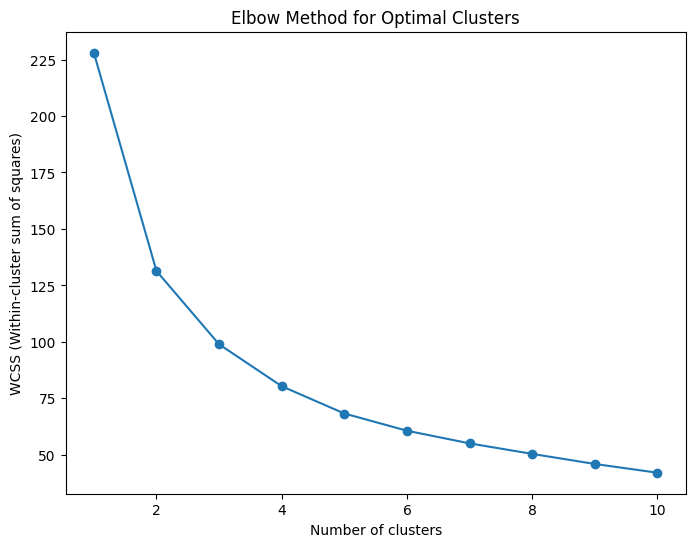


Cluster Distribution:
Cluster
1    701
0    299
Name: count, dtype: int64


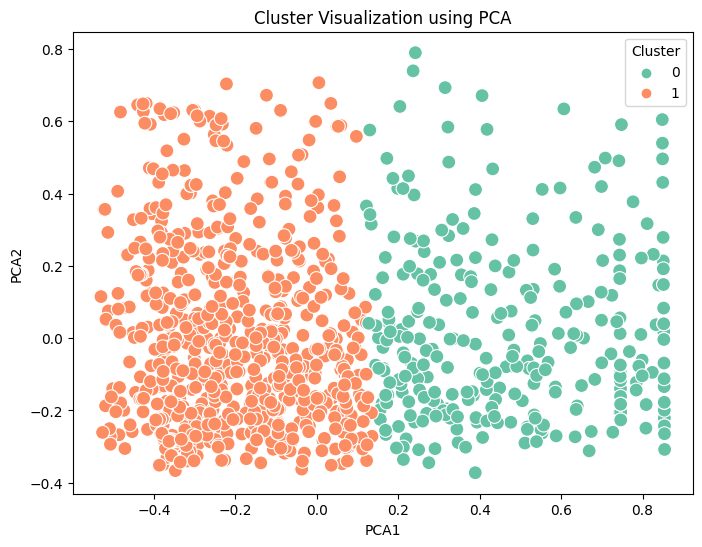

Normalized Cluster Centroids:
         Age  Credit amount  Duration  Credit_per_month  Cluster
0  0.370971       0.720126  0.748146          0.140142        0
1  0.357644       0.217101  0.293710          0.092604        1

Original Scale Cluster Centroids:
          Age  Credit amount   Duration  Credit_per_month  Cluster
0  35.879195    5746.268456  32.429530        204.793344        0
1  35.272792    1906.998575  15.160969        143.485056        1

Silhouette Score: 0.4225
Davies-Bouldin Index: 1.0340


In [5]:
# Import required libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Apply K-Means clustering
# First, we need to choose the number of clusters.
# We will use the Elbow method to determine the optimal number of clusters.

# Elbow method to find the optimal number of clusters
wcss = []  # within-cluster sum of squares
for i in range(1, 11):  # Trying from 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df[num_cols])  # Fit on numerical features
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.show()

# Fit K-Means with the optimal number of clusters
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(df[num_cols])
df['Cluster'] = kmeans.fit_predict(df[num_cols])  # Assign cluster labels

# Check the clusters assigned to the data
print("\nCluster Distribution:")
print(df['Cluster'].value_counts())

# Visualize the clusters (optional: 2D visualization using PCA)
from sklearn.decomposition import PCA

# Reduce the data to 2D using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[num_cols])

# Add PCA results to the dataframe
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='Set2', s=100)
plt.title('Cluster Visualization using PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Get cluster centroids (normalized)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=num_cols)
centroid_df['Cluster'] = range(optimal_k)
print("Normalized Cluster Centroids:\n", centroid_df)

# Get cluster centroids (original scale)
original_centroids = scaler.inverse_transform(centroids)
original_centroid_df = pd.DataFrame(original_centroids, columns=num_cols)
original_centroid_df['Cluster'] = range(optimal_k)
print("\nOriginal Scale Cluster Centroids:\n", original_centroid_df)

# Evaluate clustering quality
sil_score = silhouette_score(df[num_cols], df['Cluster'])
db_score = davies_bouldin_score(df[num_cols], df['Cluster'])

print(f"\nSilhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


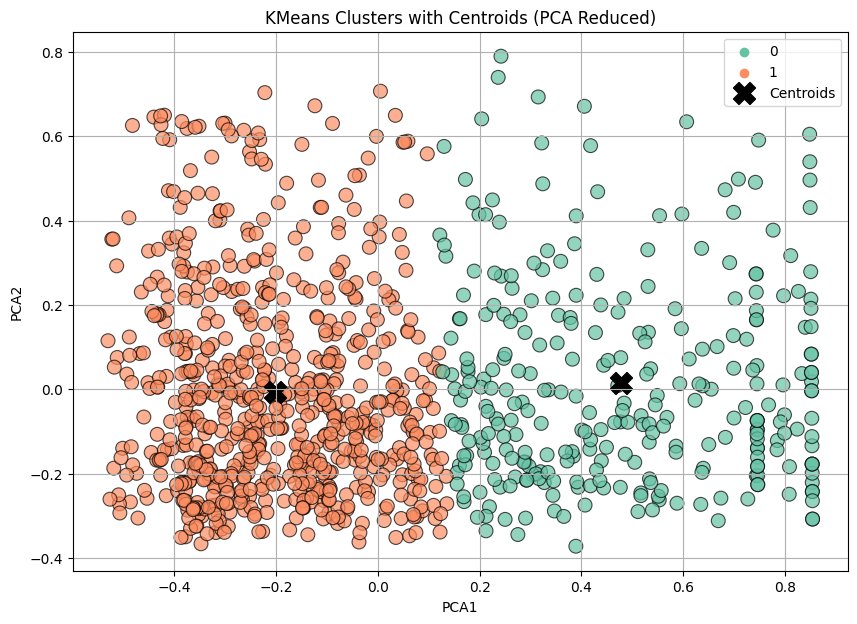

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce data to 2D using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[num_cols])
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

# Ensure kmeans is fitted
if hasattr(kmeans, 'cluster_centers_'):
    # Transform cluster centers to PCA space
    centroid_pca = pca.transform(kmeans.cluster_centers_)

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='Set2', s=100, alpha=0.7, edgecolor='k')
    plt.scatter(centroid_pca[:, 0], centroid_pca[:, 1], c='black', s=250, marker='X', label='Centroids')
    plt.title('KMeans Clusters with Centroids (PCA Reduced)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("KMeans model is not fitted. Please fit the model before plotting centroids.")


In [7]:
# Import necessary metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Get the cluster labels (from KMeans)
cluster_labels = df['Cluster']

# Calculate Silhouette Score
sil_score = silhouette_score(df[num_cols], cluster_labels)
print(f"Silhouette Score: {sil_score}")

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(df[num_cols], cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")

Silhouette Score: 0.4224755710005772
Davies-Bouldin Index: 1.0339828922402876


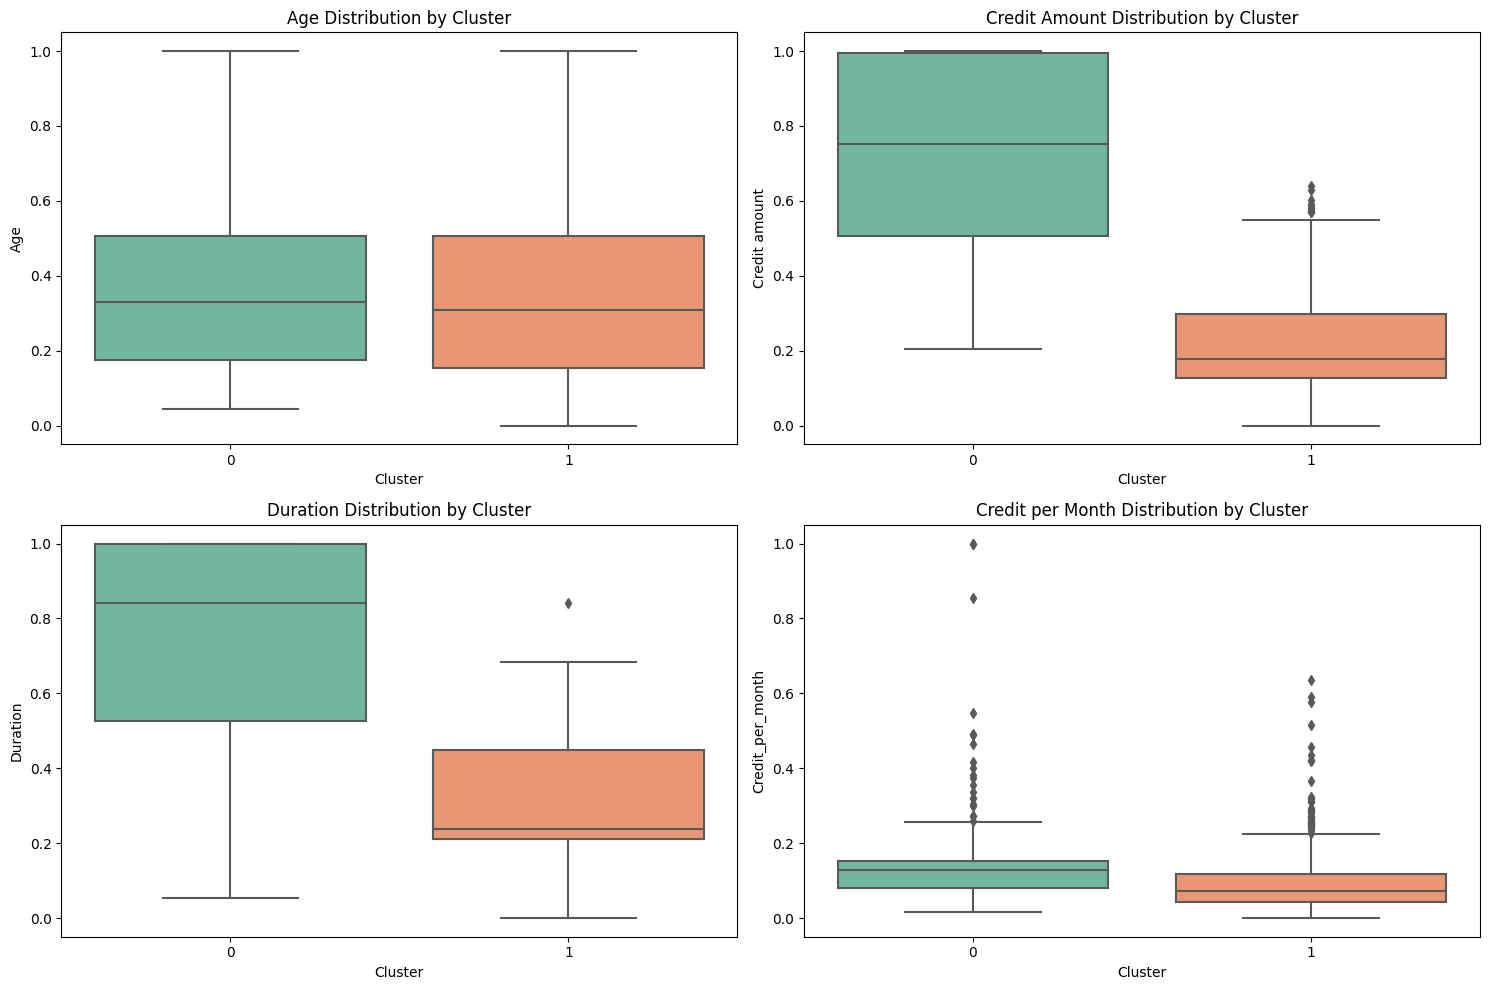

No outliers detected in Age. Skipping.
No outliers detected in Credit amount. Skipping.
No outliers detected in Duration. Skipping.
Outliers detected in Credit_per_month: 45


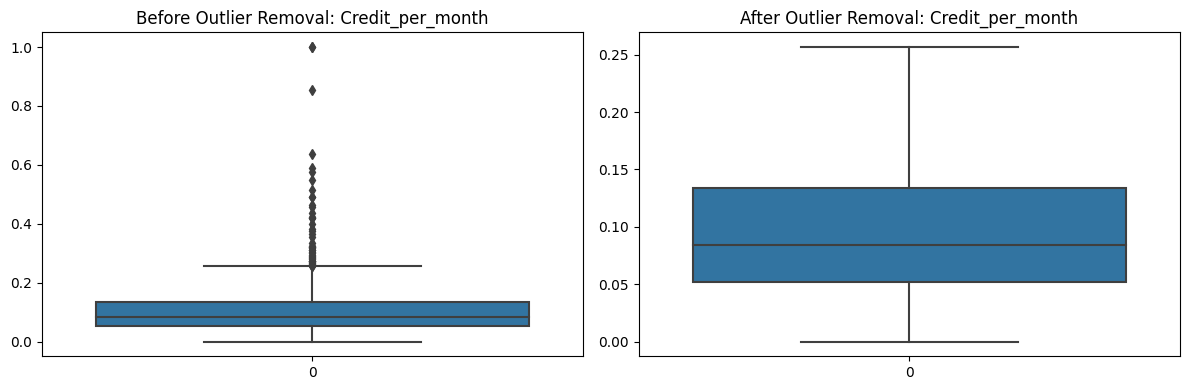

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot for 'Age'
plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Age', data=df, palette='Set2')
plt.title('Age Distribution by Cluster')

# Plot for 'Credit amount'
plt.subplot(2, 2, 2)
sns.boxplot(x='Cluster', y='Credit amount', data=df, palette='Set2')
plt.title('Credit Amount Distribution by Cluster')

# Plot for 'Duration'
plt.subplot(2, 2, 3)
sns.boxplot(x='Cluster', y='Duration', data=df, palette='Set2')
plt.title('Duration Distribution by Cluster')

# Plot for 'Credit per month'
plt.subplot(2, 2, 4)
sns.boxplot(x='Cluster', y='Credit_per_month', data=df, palette='Set2')
plt.title('Credit per Month Distribution by Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

column=["Age", "Credit amount", "Duration", "Credit_per_month"]
for col in column:
    handle_outliers_if_present(df, col)
# handle_outliers_if_present(df, column)

Accuracy: 0.9950

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.99      1.00       152

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200


Confusion Matrix:
[[ 48   0]
 [  1 151]]


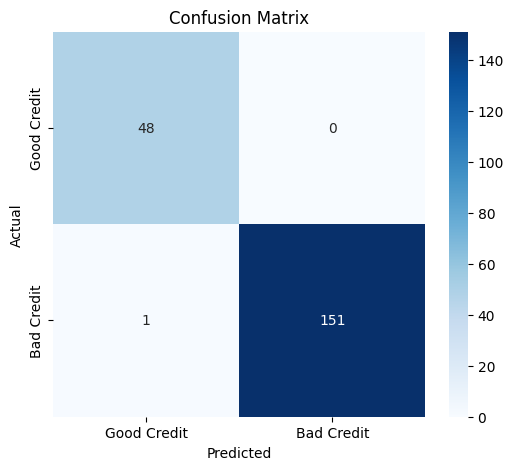

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set cluster labels as the target variable
X = df[num_cols]  # Feature matrix (numerical features)
y = df['Cluster']  # Target variable (Cluster labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting Confusion Matrix for better visualization
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good Credit', 'Bad Credit'], yticklabels=['Good Credit', 'Bad Credit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [10]:
# Handling Class Imbalance with Class Weights
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with class weights
rf_model_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf_model_balanced.fit(X_train, y_train)

# Predict on the test set
y_pred_balanced = rf_model_balanced.predict(X_test)

# Evaluate the model
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"Accuracy with class weights: {accuracy_balanced:.4f}")

# Classification report
print("\nClassification Report with Class Weights:")
print(classification_report(y_test, y_pred_balanced))

# Confusion Matrix
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
print("\nConfusion Matrix with Class Weights:")
print(cm_balanced)


Accuracy with class weights: 0.9950

Classification Report with Class Weights:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.99      1.00       152

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200


Confusion Matrix with Class Weights:
[[ 48   0]
 [  1 151]]


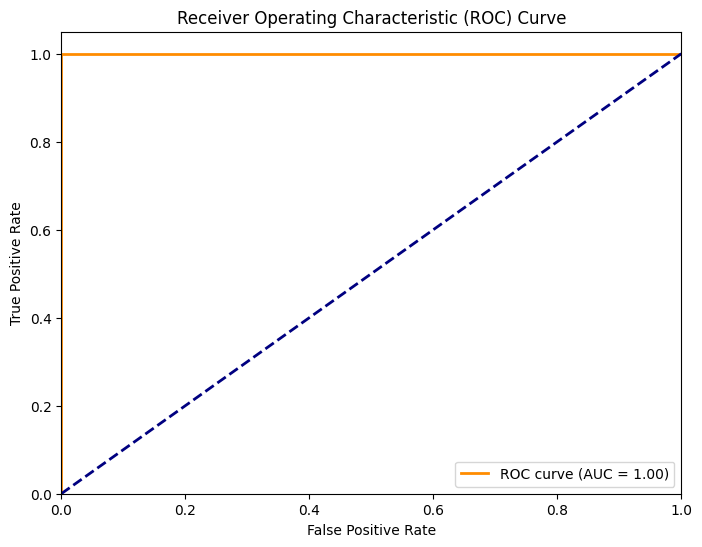

AUC Score: 1.0000


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for class 1 (bad credit risk)
y_pred_prob = rf_model_balanced.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"AUC Score: {roc_auc:.4f}")


In [12]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Before applying SMOTE: Check the class distribution
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())  # Check the class distribution in the training set

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Display the class distribution
class_distribution = pd.Series(y_resampled).value_counts()
print("Class distribution after SMOTE:")
print(class_distribution)

# Train the Random Forest classifier on the resampled data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate the model
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy with SMOTE: {accuracy_smote:.4f}")

# Classification report
print("\nClassification Report with SMOTE:")
print(classification_report(y_test, y_pred_smote))

# Confusion Matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)
print("\nConfusion Matrix with SMOTE:")
print(cm_smote)

# Save the model using Pickle
with open('rf_model_smote.pkl', 'wb') as model_file:
    pickle.dump(rf_model_smote, model_file)
    print("\nModel saved as 'rf_model_smote.pkl'")

Class distribution before SMOTE:
Cluster
1    549
0    251
Name: count, dtype: int64
Class distribution after SMOTE:
Cluster
0    549
1    549
Name: count, dtype: int64
Accuracy with SMOTE: 0.9900

Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        48
           1       1.00      0.99      0.99       152

    accuracy                           0.99       200
   macro avg       0.98      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200


Confusion Matrix with SMOTE:
[[ 48   0]
 [  2 150]]

Model saved as 'rf_model_smote.pkl'


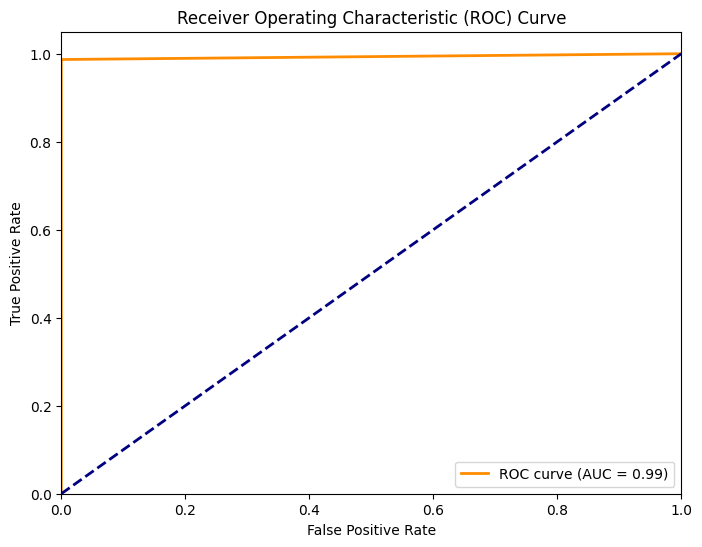

AUC Score: 0.9934


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for class 1 (bad credit risk)
y_pred_prob = rf_model_balanced.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_smote)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f"AUC Score: {roc_auc:.4f}")


In [15]:
# Load the saved model
with open('rf_model_smote.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Now you can use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
print(f"Accuracy of loaded model: {accuracy_score(y_test, y_pred_loaded):.4f}")

Accuracy of loaded model: 0.9900



Missing Values Before Scaling:
Age                               0
Sex                               0
Job                               0
Housing                           0
Saving accounts                   0
Checking account                  0
Credit amount                     0
Duration                          0
Purpose                           0
Credit_per_month                  0
Is_young                          0
Cluster                           0
PCA1                              0
PCA2                              0
log_credit_amount                 0
age_credit_interaction            0
duration_credit_interaction       0
saving_checking_interaction    1000
dtype: int64

Missing Values After Scaling:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
dtype: int64

Silhouette Score: 0.297861825152433
Davies-Bouldin Score: 1.4364663426753215


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['saving_checking_interaction']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


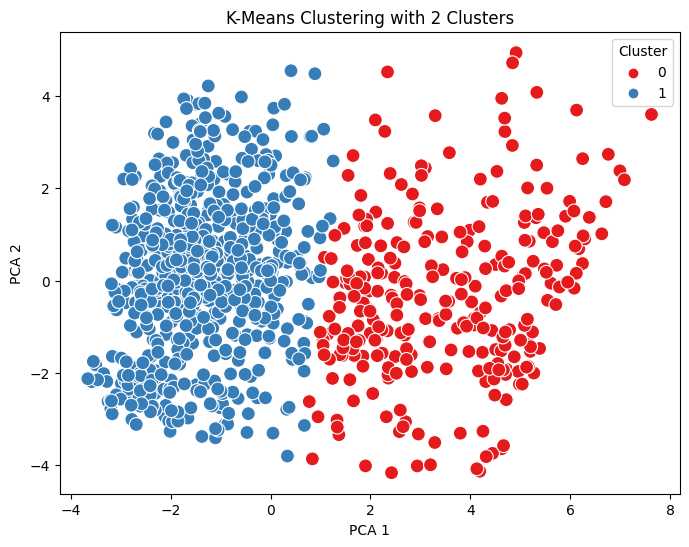


Cluster Mean Values:
              Age       Sex       Job   Housing  Saving accounts  \
Cluster                                                            
0        0.385006  0.768683  2.153025  0.921708         1.249110   
1        0.352474  0.659249  1.806676  1.129346         1.048679   

         Checking account  Credit amount  Duration   Purpose  \
Cluster                                                        
0                1.494662       0.748761  0.740214  2.387900   
1                1.609179       0.217803  0.307554  3.069541   

         Credit_per_month  Is_young      PCA1      PCA2  log_credit_amount  \
Cluster                                                                      
0                0.133825  0.103203  0.492407  0.032181           0.550408   
1                0.087043  0.166898 -0.192443 -0.012577           0.192013   

         age_credit_interaction  duration_credit_interaction  \
Cluster                                                        
0      

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


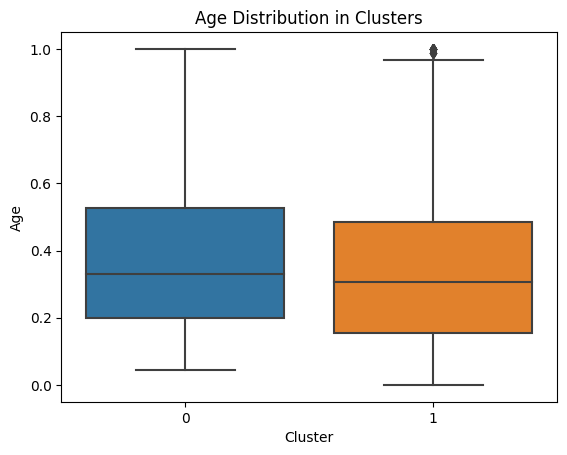

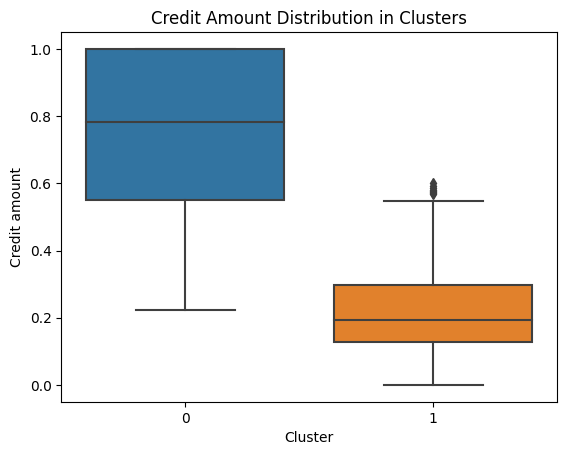


Sex distribution in clusters:
Sex        0    1
Cluster          
0         65  216
1        245  474

Housing distribution in clusters:
Housing   0    1    2
Cluster              
0        59  185   37
1        49  528  142


In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer

# Log transformation for highly skewed features (e.g., Credit amount)
df['log_credit_amount'] = np.log(df['Credit amount'] + 1)  # Adding 1 to avoid log(0)

# Interaction term between Age and Credit amount (a combination that might reflect financial maturity)
df['age_credit_interaction'] = df['Age'] * df['Credit amount']

# Interaction term between Duration and Credit amount (may indicate financial commitment)
df['duration_credit_interaction'] = df['Duration'] * df['Credit amount']

# Interaction term between Saving accounts and Checking account (might reflect liquidity management)
df['saving_checking_interaction'] = df['Saving accounts'].map({'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3}) * df['Checking account']

# Handle missing values (use SimpleImputer to fill missing values with the mean)
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean
df_imputed = imputer.fit_transform(df)

# Standardize the data (KMeans works better with normalized data)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

# Check for missing values before and after scaling
missing_before_scaling = df.isnull().sum()
missing_after_scaling = pd.DataFrame(df_scaled).isnull().sum()

print("\nMissing Values Before Scaling:")
print(missing_before_scaling)

print("\nMissing Values After Scaling:")
print(missing_after_scaling)

# K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Evaluate the clustering performance using silhouette score and Davies-Bouldin score
silhouette = silhouette_score(df_scaled, df['Cluster'])
davies_bouldin = davies_bouldin_score(df_scaled, df['Cluster'])

# Output the clustering evaluation scores
print(f"\nSilhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")

# Cluster visualization (2D scatter plot using first two principal components of the dataset)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['Cluster'], palette='Set1', s=100)
plt.title('K-Means Clustering with 2 Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# Interpret the Clusters
# Calculate the mean values of features for each cluster
cluster_means = df.groupby('Cluster').mean()
print("\nCluster Mean Values:")
print(cluster_means)

# Visualize the distribution of key features within each cluster (e.g., Age, Credit Amount, etc.)
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Age Distribution in Clusters')
plt.show()

sns.boxplot(x='Cluster', y='Credit amount', data=df)
plt.title('Credit Amount Distribution in Clusters')
plt.show()

# Additional analysis for categorical features
sex_distribution = df.groupby(['Cluster', 'Sex']).size().unstack()
print("\nSex distribution in clusters:")
print(sex_distribution)

housing_distribution = df.groupby(['Cluster', 'Housing']).size().unstack()
print("\nHousing distribution in clusters:")
print(housing_distribution)

In [17]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

X_scaled

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:82: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


array([[ 2.61662036e+00,  6.70280063e-01,  1.46949180e-01, ...,
        -8.95790477e-02, -7.68034008e-01,             nan],
       [-1.21194299e+00, -1.49191369e+00,  1.46949180e-01, ...,
        -5.42005930e-01,  2.04123358e+00,             nan],
       [ 1.22032079e+00,  6.70280063e-01, -1.38377145e+00, ...,
         1.58782924e-01, -5.98928654e-01,             nan],
       ...,
       [ 2.29398508e-01,  6.70280063e-01,  1.46949180e-01, ...,
        -6.62419972e-01, -7.34108309e-01,             nan],
       [-1.12185915e+00,  6.70280063e-01,  1.46949180e-01, ...,
        -7.38326406e-01,  6.17178957e-04,             nan],
       [-7.61523771e-01,  6.70280063e-01,  1.46949180e-01, ...,
        -2.21518198e-01,  1.35788055e+00,             nan]])